In [1]:
%reload_ext autoreload
%autoreload 2

In [117]:
# system
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Home Grown
sys.path.append(".")
sys.path.append("../fMRI_Processing")
import fit_IEM_v1 as IEM
import fit_IEM_v2 as IEM2
from DecodeSNC_CViter import DecodeSNC_CViter
from circ_corr import circ_corrcc_better as c_corr

# Visualization
import seaborn as sns
from matplotlib import rc
font = {'family':'DejaVu Sans','size'   : 16}
rc('font', **font)

from pycircstat import mean as cmean
# ccorr = pycircstat.corrcc

In [2]:
def nanc_corr(x,y):
    good_x = ~np.isnan(x)
    x=x[good_x]
    y=y[good_x]
    good_y = ~np.isnan(y)
    x=x[good_y]
    y=y[good_y]
    return c_corr(x,y)

# Import and extract data

In [20]:
subjs = ['UCSD0' + x for x in ['54','60','61','62']]
DAT = pd.Series()
for subj in subjs:
    dat_loc = '/mnt/neurocube/local/serenceslab/tsheehan/CD_Task/SignalProcessing/' + subj +'_dat.pickle'
    dat = pd.read_pickle(dat_loc)
    DAT[subj] = dat
print(DAT[subj].keys())

Index(['EV_LOC', 'DAT_LOC', 'EV_TASK', 'DAT_TASK'], dtype='object')


# Select Voxels from localizer and Task

In [22]:
DC_ALL = pd.Series() # dat clean all subjects

for subj in subjs:
    print('Initializing: %s...' %subj)
    DC_LOC = pd.Series() # dat clean localizer
    DC_TASK = pd.Series() # dat clean task

    D_LOC = DAT[subj]['DAT_LOC']
    E_LOC = DAT[subj]['EV_LOC']
    D_TASK = DAT[subj]['DAT_TASK']
    
    donut = 50
    ori = 50 # or hard vox
    max_vox = 100
    roi = 'V1'
    for roi in D_LOC.keys():

        this_dat = D_LOC[roi] # roi x EV
        print('Initial Localizer Data:',this_dat.shape, roi)
        ind_roi_use = np.arange(this_dat.shape[0])

        # Donut loc
        # E_LOC.head() # d1- 1.0-donut, 2.0- hole
        dat_out = this_dat[:,E_LOC.d1==1.0]
        dat_in = this_dat[:,E_LOC.d1==2.0]
        t_scores,_ = stats.ttest_ind(dat_out.T,dat_in.T)
        cutoff_donut = np.percentile(t_scores,donut)
        dat_use_0 = dat_out[t_scores>cutoff_donut,:]
        ind_roi_use = ind_roi_use[t_scores>cutoff_donut]

        # angle loc
        E_Donut = E_LOC[E_LOC.d1==1.0]
        angles_anova =  np.round((E_Donut.d0-10)/2,-1) 
        f_stats = IEM2.anova1(dat_use_0,angles_anova) # NB: Circularity here, will need to bootstrap! 
        n_vox,_ = dat_use_0.shape
        n_keep = np.minimum(100,n_vox*ori/100)
        cutoff_pct_anova = 100*(1-n_keep/n_vox)
        cutoff_anova =  np.percentile(f_stats,cutoff_pct_anova)
        dat_use_1 = dat_use_0[f_stats>cutoff_anova,:].T
        ind_roi_use = ind_roi_use[f_stats>cutoff_anova]

        # grab task data
        dat_use_task = D_TASK[roi][ind_roi_use,:].T

        # make master data-holder
        DC_LOC[roi] = dat_use_1
        DC_TASK[roi] = dat_use_task

    DC_TASK_T = pd.Series()
    DC_LOC_T = pd.Series()
    for k in DC_TASK.keys():
        DC_TASK_T[k] = DC_TASK[k].T
        DC_LOC_T[k] = DC_LOC[k].T
    
    DC_THIS = pd.Series({'DC_TASK':DC_TASK,'DC_TASK_T':DC_TASK_T,'DC_LOC':DC_LOC,'DC_LOC_T':DC_LOC_T})
    DC_ALL[subj] = DC_THIS

Initializing: UCSD054...
Initial Localizer Data: (522, 324) TO
Initial Localizer Data: (4733, 324) V3
Initial Localizer Data: (662, 324) LO
Initial Localizer Data: (3007, 324) IPS
Initial Localizer Data: (938, 324) VO
Initial Localizer Data: (709, 324) hv4
Initial Localizer Data: (2201, 324) V2
Initial Localizer Data: (2117, 324) V1
Initial Localizer Data: (14889, 324) ALL
Initializing: UCSD060...
Initial Localizer Data: (528, 252) TO
Initial Localizer Data: (2745, 252) V3
Initial Localizer Data: (3866, 252) IPS
Initial Localizer Data: (601, 252) LO
Initial Localizer Data: (564, 252) hv4
Initial Localizer Data: (577, 252) VO
Initial Localizer Data: (1734, 252) V2
Initial Localizer Data: (2915, 252) V1
Initial Localizer Data: (13530, 252) ALL
Initializing: UCSD061...
Initial Localizer Data: (1316, 684) LO
Initial Localizer Data: (788, 684) hv4
Initial Localizer Data: (3522, 684) V3
Initial Localizer Data: (4951, 684) IPS
Initial Localizer Data: (2638, 684) V1
Initial Localizer Data: (24

# Train and Test Localizer SNC

In [32]:
# set up a few variables here for dealing with LOO-CV
OUT_LOC_LOC_SUBJ = pd.Series()
for subj in subjs:
    this_dat = DC_ALL[subj]
    E_LOC = DAT[subj]['EV_LOC']
    E_Donut = E_LOC[E_LOC.d1==1.0]
    
    n_ev_loc = len(E_Donut)
    
    OUT_LOC_LOC = pd.Series()
    p = {"nchans" : 8, "span" : 180, "ninit" : 30}
    p['stimfeat'] = E_Donut.d0.values
    p['runNs'] = E_Donut.block.values
    runs = np.unique(p['runNs'])
    for roi in DC_LOC.keys():
#     for roi in ['V1']:

        print(roi)
        p['samples'] = this_dat['DC_LOC'][roi]# should be trials by voxels

        def run_cross_val(run):
            p["test_trials"] = (p["runNs"]==runs[run])
            OUT = DecodeSNC_CViter(p["samples"], p); 
            if type(OUT) is int:
                print(testrun_idx,'Failed')
                return OUT
            else:
                e,u,_ = OUT
                return (e,u,p["test_trials"])
        # Do Work
        inds = np.arange(len(runs))
        with Pool(10) as P:
            BIG_OUT = P.map(run_cross_val,inds)

        # unpack cross-vals
        est = np.full(n_ev_loc, np.nan)
        unc = np.full(n_ev_loc, np.nan)
        for b in range(len(BIG_OUT)):
            b=BIG_OUT[b]
            if type(b) is int:
                continue
            e,u,ind = b
            est[ind],unc[ind] = e,u
            
        OUT_LOC_LOC[roi] = pd.Series({'est':est,'unc':unc,'stim':p['stimfeat']})
    OUT_LOC_LOC_SUBJ[subj] = OUT_LOC_LOC

V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logd

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: Ru

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(ncha

V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tshee

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((

Failed: 1
Failed: 1
Failed: 2
V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alp

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 2
Failed: 3


# Visualize for given ROI

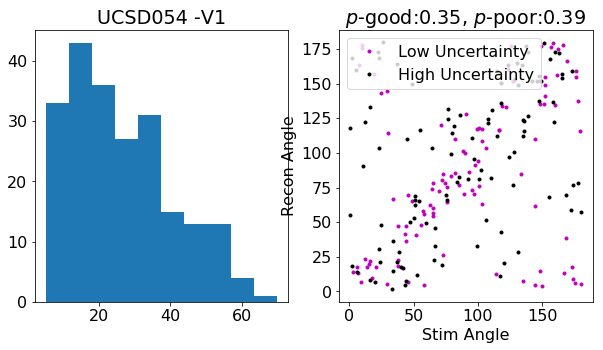

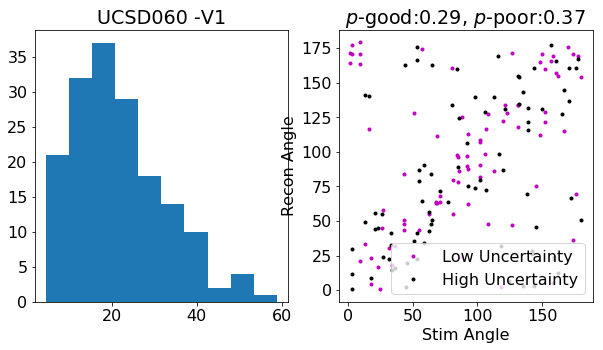

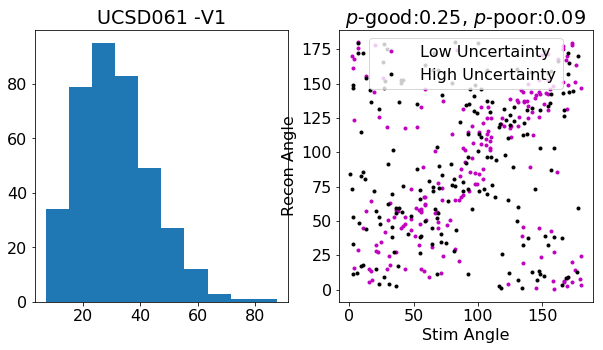

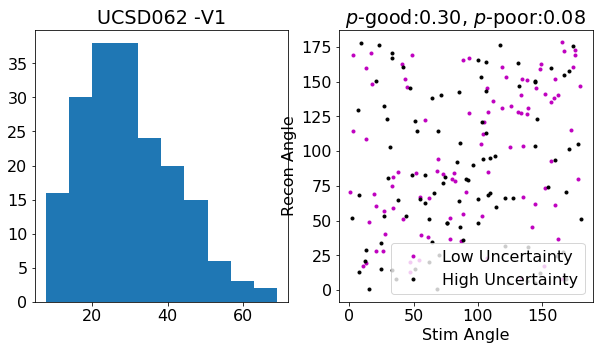

In [39]:
for subj in subjs:
    roi = 'V1'
    # dat = OUT_LOC_LOC[roi]
    dat = OUT_LOC_LOC_SUBJ[subj][roi]
#     stimfeat = p['stimfeat']
    stimfeat = dat['stim']
    use = ~np.isnan(dat.unc)
    est_use = dat['est'][use]
    unc_use = dat['unc'][use]
    stimfeat_use=stimfeat[use]
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.hist(unc_use)
    plt.title('%s -%s' %(subj,roi))
    plt.subplot(122)

    good= unc_use<np.median(unc_use)
    plt.plot(stimfeat_use[good],est_use[good],'m.')
    plt.plot(stimfeat_use[~good],est_use[~good],'k.')
    plt.xlabel('Stim Angle')
    plt.ylabel('Recon Angle')
    plt.legend(('Low Uncertainty','High Uncertainty'))
    cc_good=np.corrcoef(stimfeat_use[good],est_use[good])[1,0]
    cc_poor=np.corrcoef(stimfeat_use[~good],est_use[~good])[1,0]
    plt.title('$p$-good:%.2f, $p$-poor:%.2f' %(cc_good,cc_poor))
    plt.show()


# Train Loc Test Task SNC

In [45]:
OUT_LOC_TASK_SUBJ = pd.Series()

for subj in subjs:

    this_dat = DC_ALL[subj]
    E_LOC = DAT[subj]['EV_LOC']
    E_Donut = E_LOC[E_LOC.d1==1.0]
    E_TASK = DAT[subj]['EV_TASK']
    
    n_ev_loc = len(E_Donut)
    n_ev_task = len(E_TASK)
    OUT_LOC_TASK = pd.Series()

    p = {"nchans" : 8, "span" : 180, "ninit" : 30} # cleaner to reset p on each iter
    o_task = E_TASK.orient0.values.copy()
    o_task[o_task<0] =180+o_task[o_task<0]
    o_loc = E_Donut.d0.values
    stimfeat = np.concatenate([o_loc,o_task])

    p['runNs'] = np.concatenate([np.ones(n_ev_loc)*0,np.ones(n_ev_task)*1])
    runs = np.unique(p['runNs'])
    p['stimfeat'] = stimfeat
    for roi in DC_LOC.keys():
#     for roi in ['V1']:
        print(roi)
        est = np.full(p["runNs"].shape, np.nan)
        unc = np.full(p["runNs"].shape, np.nan)
#         p['samples'] = np.concatenate([DC_LOC[roi],DC_TASK[roi]])
        p['samples'] = np.concatenate([this_dat['DC_LOC'][roi],this_dat['DC_TASK'][roi]])
        for testrun_idx in np.arange(len(runs)):
            p["test_trials"] = (p["runNs"]==runs[testrun_idx]) 
            OUT = DecodeSNC_CViter(p["samples"], p);  
            if type(OUT) is int:
                print(testrun_idx,'Failed')
                continue
            est[p["test_trials"]], unc[p["test_trials"]],out  = OUT
            print(testrun_idx,'Complete')
        OUT_LOC_TASK[roi] = pd.Series({'est':est,'unc':unc,'stim':p['stimfeat'],'group':p['runNs']})
    OUT_LOC_TASK_SUBJ[subj] = OUT_LOC_TASK

V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
0 Complete
1 Complete
V1
0 Complete
1 Complete
V1
0 Complete
1 Complete
V1
Failed: 1
Failed: 2
Failed: 3
Failed: 4
Failed: 5
0 Complete
1 Complete


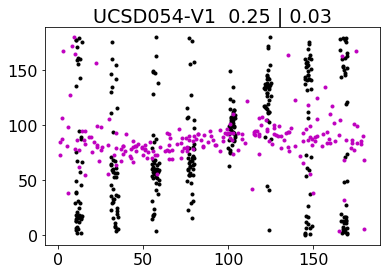

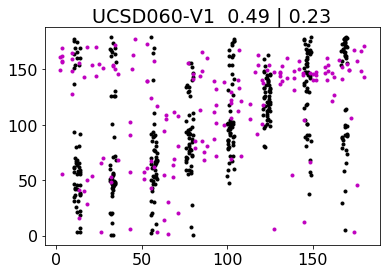

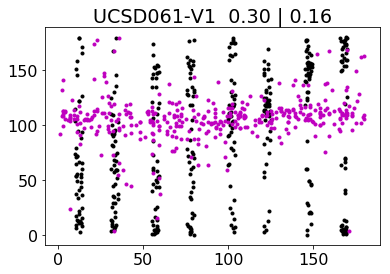

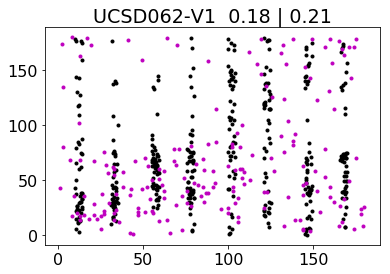

In [57]:
for subj in subjs:
    roi = 'V1'
    # dat = OUT_LOC_LOC[roi]
    dat = OUT_LOC_TASK_SUBJ[subj][roi]
    stim = dat['stim']
    group = dat['group']
    est = dat['est']

    plt.plot(stim[group==1],est[group==1],'k.') # task
    plt.plot(stim[group==0],est[group==0],'m.') # loc
    plt.title('%s-%s  %.2f | %.2f' %(subj,roi,c_corr(stim[group==1],est[group==1]),c_corr(stim[group==0],est[group==0])))
    plt.show()

# Train and Test Task

In [60]:
# do with pool because so many blocks...
OUT_TASK_TASK_SUBJ = pd.Series()

for subj in subjs:
    OUT_TASK_TASK = pd.Series()
    
    this_dat = DC_ALL[subj]['DC_TASK']
    E_TASK = DAT[subj]['EV_TASK']
    
    n_ev_loc = len(E_Donut)
    n_ev_task = len(E_TASK)
    OUT_LOC_TASK = pd.Series()
    
    o_task = E_TASK.orient0.values.copy()
    o_task[o_task<0] =180+o_task[o_task<0]
    
    
    p = {"nchans" : 8, "span" : 180, "ninit" : 30}
    p['stimfeat'] = o_task
    p['runNs'] = E_TASK.sess
    runs = np.unique(p['runNs'])
    for roi in DC_TASK.keys():
#     for roi in ['V1']:
        print(roi)
        p['samples'] = this_dat[roi]# should be trials by voxels
        def run_cross_val(run):
            p["test_trials"] = (p["runNs"]==runs[run])
            OUT = DecodeSNC_CViter(p["samples"], p); 
            if type(OUT) is int:
                print(testrun_idx,'Failed')
                return OUT
            else:
                e,u,_ = OUT
                return (e,u,p["test_trials"])
        inds = np.arange(len(runs))
        with Pool(10) as P:
            BIG_OUT = P.map(run_cross_val,inds)

        est = np.full(n_ev_task, np.nan)
        unc = np.full(n_ev_task, np.nan)
        for b in range(len(BIG_OUT)):
            b=BIG_OUT[b]
            if type(b) is int:
                continue
            e,u,ind = b
            est[ind],unc[ind] = e,u
        OUT_TASK_TASK[roi] = pd.Series({'est':est,'unc':unc,'stim':p['stimfeat']})
    OUT_TASK_TASK_SUBJ[subj]=OUT_TASK_TASK

V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))


Failed: 2
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 3
Failed: 1
Failed: 1
Failed: 4
Failed: 4
Failed: 4
Failed: 2
Failed: 1
Failed: 1
Failed: 1
Failed: 2
Failed: 2
Failed: 3
Failed: 2
Failed: 3
Failed: 2
Failed: 1
Failed: 3
Failed: 2
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:53: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 4
Failed: 1
Failed: 2
Failed: 2
Failed: 1
Failed: 5


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 2
Failed: 1
Failed: 1
Failed: 2


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2
Failed: 3
Failed: 3
Failed: 1
Failed: 4
Failed: 4
Failed: 5
Failed: 2
Failed: 5
Failed: 6
Failed: 6


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: invalid value encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: divide by zero encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:87: RuntimeWarning: invalid value encountered in multiply
  return (b-a)/2.0 * np.sum(w*func(y, *args), axis=-1), None


Failed: 7
Failed: 8


/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (600) exceeded. Latest difference = nan
  AccuracyWarning)
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (600) exceeded. Latest difference = 1.560947e+225
  AccuracyWarning)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


V1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:93: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:63: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rh

Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 2
Failed: 3
Failed: 3
Failed: 3
Failed: 4
Failed: 1
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 1
Failed: 5
Failed: 4
Failed: 1


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 2
Failed: 2
Failed: 2
Failed: 6
Failed: 2
Failed: 5
Failed: 3


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:55: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2)))


Failed: 3
Failed: 7
Failed: 3
Failed: 1
Failed: 6
Failed: 1
Failed: 4
Failed: 4
Failed: 8
Failed: 1
Failed: 2
Failed: 2
Failed: 1
Failed: 7
Failed: 9
Failed: 5
Failed: 2
Failed: 3
Failed: 3
Failed: 2
Failed: 8
Failed: 6


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: invalid value encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:32: RuntimeWarning: divide by zero encountered in true_divide
  out = (fun_lik(s)/Integ)*np.exp(1j*s)
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:87: RuntimeWarning: invalid value encountered in multiply
  return (b-a)/2.0 * np.sum(w*func(y, *args), axis=-1), None


Failed: 3
Failed: 4
Failed: 3
Failed: 1
Failed: 9
Failed: 4
Failed: 4
Failed: 5
Failed: 1
Failed: 2


/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (600) exceeded. Latest difference = nan
  AccuracyWarning)


Failed: 5
Failed: 5
Failed: 2
Failed: 6
Failed: 3
Failed: 7


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


Failed: 8


/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/DecodeSNC.py:65: RuntimeWarning: invalid value encountered in sqrt
  unc[i] = np.sqrt(-2*np.log(np.abs(E1)))/pi*90


Failed: 9


# Organize Noise data for plotting

In [80]:
roi = 'V1'
subj = 'UCSD061'
stim_task = OUT_TASK_TASK_SUBJ[subj][roi]['stim']
stim_loc = OUT_LOC_LOC_SUBJ[subj][roi]['stim']


c_mean_loc_task = OUT_LOC_TASK_SUBJ[subj][roi]['est'][len(stim_loc):]
c_mean_task_task = OUT_TASK_TASK_SUBJ[subj][roi]['est']
c_mean_loc_loc = OUT_LOC_LOC_SUBJ[subj][roi]['est']


Text(0.5,1,'V1 Tr:L, Tst:L $p=$ 0.174')

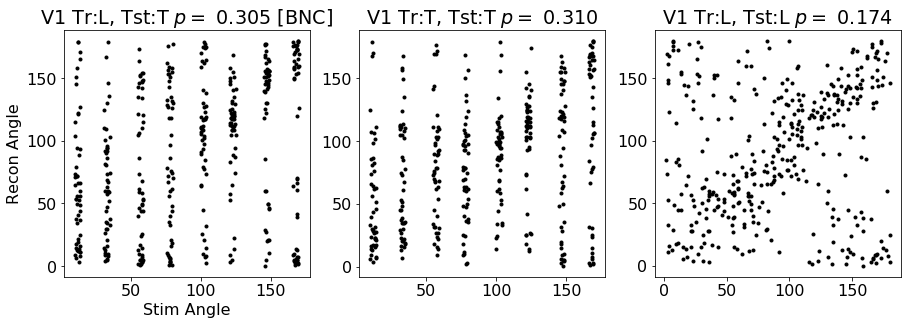

In [81]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(stim_task,c_mean_loc_task,'k.')
cc_good = nanc_corr(stim_task,c_mean_loc_task)
plt.title('%s Tr:L, Tst:T $p=$ %.3f [BNC]' %(roi,cc_good))
plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')

plt.subplot(232)
plt.plot(stim_task,c_mean_task_task,'k.')
cc_good = nanc_corr(stim_task,c_mean_task_task)
plt.title('%s Tr:T, Tst:T $p=$ %.3f' %(roi,cc_good))

plt.subplot(233)
plt.plot(stim_loc,c_mean_loc_loc,'k.')
cc_good = nanc_corr(stim_loc,c_mean_loc_loc)
plt.title('%s Tr:L, Tst:L $p=$ %.3f' %(roi,cc_good))

# Visualize Serial Bias

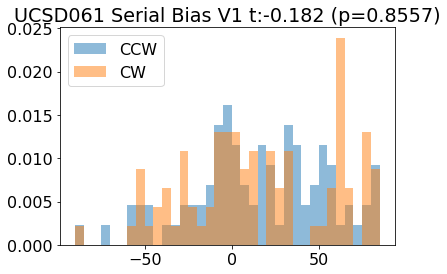

In [82]:
E_recon = c_mean_loc_task - o_task
E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])

grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)#&~good
grp2 = (E_TASK.SB==1)&(E_TASK.cardinal==0)#&~good

SB_CCW = E_recon[grp0]
SB_CW = E_recon[grp2]
bns = np.arange(-90,90,5)
plt.hist(SB_CCW,alpha=.5,bins=bns,density=True)
plt.hist(SB_CW,alpha=.5,bins=bns,density=True)

ts = stats.ttest_ind(SB_CCW,SB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Serial Bias %s t:%.3f (p=%.4f)' %(subj,roi,ts[0],ts[1]))
plt.show()

# Train and Test IEM for all ROIS

In [104]:
# fit IEM to data
# LOC -> MEM
IEM_LOC_TASK = pd.Series()
IEM_TASK_TASK = pd.Series()
IEM_LOC_LOC = pd.Series()
for subj in subjs:
    print(subj)
    D = DC_ALL[subj] # this dat
    E_TASK = DAT[subj]['EV_TASK']
    E_LOC = DAT[subj]['EV_LOC']
    E_Donut = E_LOC[E_LOC.d1==1.0]
    M_all = IEM2.build_model(E_Donut,D.DC_LOC,donut_thresh=0,anova_thresh=0,pre_cleaned=1)
    IEM_LOC_TASK[subj] = IEM2.fit_model(M_all,D.DC_TASK,pre_cleaned=1) 
    # MEM->MEM
    IEM_TASK_TASK[subj] = IEM.fit_by_roi(D.DC_TASK_T,ang=np.round(E_TASK.orient0.values).astype(int),G=E_TASK.sess,center=0)
    # LOC->LOC
    IEM_LOC_LOC[subj] = IEM.fit_by_roi(D.DC_LOC_T,ang=np.floor(E_Donut.d0.values).astype(int),G=E_Donut.sess,center=0)
    

UCSD054
UCSD060
UCSD061
UCSD062


In [125]:
roi = 'IPS'
subj = 'UCSD054'
stim_task = np.round(OUT_TASK_TASK_SUBJ[subj]['V1']['stim']).astype(int)
stim_loc = OUT_LOC_LOC_SUBJ[subj]['V1']['stim']

this_dat = IEM_LOC_TASK[subj][roi]
n_trials = len(E_TASK)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(this_dat.shape[0],1))
c_mean = cmean(iem_locs,this_dat,axis=1)
c_mean[c_mean>np.pi]-=np.pi*2
c_mean*=90/np.pi
c_mean+=90
c_mean_loc_task = c_mean
output_cent_loc_task = IEM2.center_resp(this_dat,stim_task)

# TASK TASK
this_dat = IEM_TASK_TASK[subj][roi]
n_trials = len(E_TASK)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(this_dat.shape[0],1))
c_mean = cmean(iem_locs,this_dat,axis=1)
c_mean*=90/np.pi
c_mean_task_task = c_mean
output_cent_task_task = IEM2.center_resp(this_dat,stim_task)

# LOC LOC
this_dat = IEM_LOC_LOC[subj][roi]
angs = np.floor(E_Donut.d0.values).astype(int)
n_trials = len(E_Donut)
iem_locs = np.arange(0,180)/90*np.pi+np.pi/180
iem_locs = np.tile(iem_locs,(this_dat.shape[0],1))
c_mean = cmean(iem_locs,this_dat,axis=1)
c_mean_og = c_mean.copy()
c_mean*=90/np.pi
c_mean_loc_loc = c_mean
output_cent_loc_loc = IEM2.center_resp(this_dat,stim_loc)

# Visaulize Reconstruction Fidelity IEM

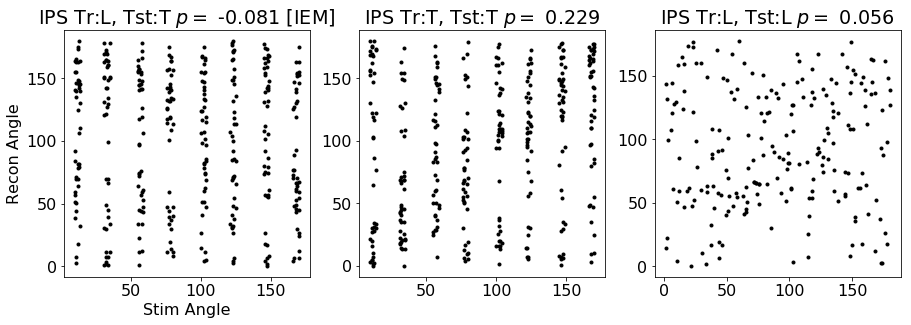

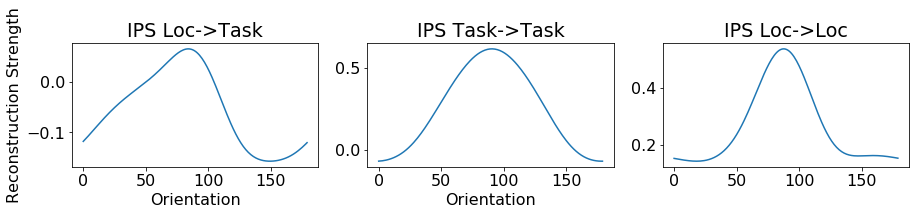

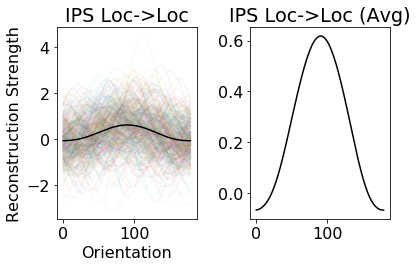

In [126]:
plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(stim_task,c_mean_loc_task,'k.')
cc_good = c_corr(stim_task,c_mean_loc_task)
plt.title('%s Tr:L, Tst:T $p=$ %.3f [IEM]' %(roi,cc_good))
plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')

plt.subplot(232)
plt.plot(stim_task,c_mean_task_task,'k.')
cc_good = nanc_corr(stim_task,c_mean_task_task)
plt.title('%s Tr:T, Tst:T $p=$ %.3f' %(roi,cc_good))

plt.subplot(233)
plt.plot(stim_loc,c_mean_loc_loc,'k.')
cc_good = c_corr(stim_loc,c_mean_loc_loc)
plt.title('%s Tr:L, Tst:L $p=$ %.3f' %(roi,cc_good))
# plt.show()

plt.figure(figsize=(15,5))
plt.subplot(234)
plt.plot(np.mean(output_cent_loc_task,0))
plt.title('%s Loc->Task' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(235)
plt.plot(np.mean(output_cent_task_task,0))
plt.title('%s Task->Task' %roi)
plt.xlabel('Orientation')
plt.subplot(236)
plt.plot(np.mean(output_cent_loc_loc,0))
plt.title('%s Loc->Loc' %roi)
plt.show()

plt.subplot(1,2,1)
plt.plot(output_cent_task_task.T,alpha=.05)
plt.plot(np.mean(output_cent_task_task,0),'k')
plt.title('%s Loc->Loc' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(1,2,2)
plt.plot(np.mean(output_cent_task_task,0),'k')
plt.title('%s Loc->Loc (Avg)' %roi)
plt.tight_layout()
plt.show()

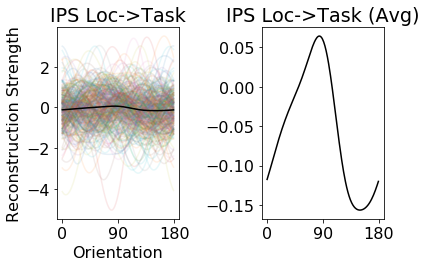

In [127]:
# dat = output_cent_loc_loc
# plt.subplot(1,2,1)
# plt.plot(dat.T,alpha=.1)
# plt.plot(np.mean(dat,0),'k')
# plt.axis('tight')
# plt.title('%s Loc->Loc' %roi)
# plt.xlabel('Orientation')
# plt.ylabel('Reconstruction Strength')
# plt.subplot(1,2,2)
# plt.plot(np.mean(dat,0),'k')
# plt.title('%s Loc->Loc (Avg)' %roi)
# plt.tight_layout()
# plt.show()

dat = output_cent_loc_task
plt.subplot(1,2,1)
plt.plot(dat.T,alpha=.1)
plt.plot(np.mean(dat,0),'k')
plt.xticks((0,90,180))
plt.title('%s Loc->Task' %roi)
plt.xlabel('Orientation')
plt.ylabel('Reconstruction Strength')
plt.subplot(1,2,2)
plt.plot(np.mean(dat,0),'k')
plt.title('%s Loc->Task (Avg)' %roi)
plt.xticks((0,90,180))
plt.tight_layout()
plt.show()

# Visualize Serial and Cardinal Biases

In [128]:
# look at sign of recon error relative to SB
E_recon = c_mean_loc_task - o_task
E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])

grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)#&~good
grp2 = (E_TASK.SB==1)&(E_TASK.cardinal==0)#&~good

SB_CCW = E_recon[grp0]
SB_CW = E_recon[grp2]
bns = np.arange(-90,90,5)
plt.hist(SB_CCW,alpha=.5,bins=bns)
plt.hist(SB_CW,alpha=.5,bins=bns)

ts = stats.ttest_ind(SB_CCW,SB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Serial Bias %s t:%.3f (p=%.4f)' %(subj,roi,ts[0],ts[1]))
plt.xlabel('Recon - Presented Orientation')
plt.ylabel('# Trials')
plt.xticks([-45,0,45])
plt.show()

ValueError: operands could not be broadcast together with shapes (357,) (408,) 

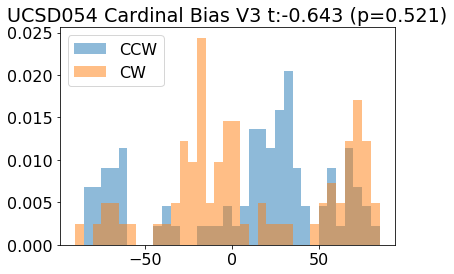

In [1099]:
grp0 = (E_TASK.CB==-1)#&~good
grp2 = (E_TASK.CB==1)#&~good
CB_CCW = E_recon[grp0]
CB_CW = E_recon[grp2]

bns = np.arange(-90,90,5)
plt.hist(CB_CCW,alpha=.5,bins=bns,density=True)
plt.hist(CB_CW,alpha=.5,bins=bns,density=True)

ts = stats.ttest_ind(CB_CCW,CB_CW)
plt.legend(('CCW','CW'))
plt.title('%s Cardinal Bias %s t:%.3f (p=%.3f)' %(subj,roi,ts[0],ts[1]))
plt.show()

# Quantify Both

In [130]:
corr_coefs_B = pd.DataFrame()
BIAS_B = pd.DataFrame()

cc_key = ['LocTask','TaskTask','LocLoc']
train_on_key = ['Loc','Task']
uncert_key = ['poor','all']
roi_want = ['V1','V2','V3','hv4','IPS','ALL']
iem_base = np.arange(0,180)/90*np.pi+np.pi/180

for subj in subjs:
    E_TASK = DAT[subj]['EV_TASK']
    E_LOC = DAT[subj]['EV_LOC']
    E_Donut = E_LOC[E_LOC.d1==1.0]
    n_ev_task = len(E_TASK)
    n_ev_loc = len(E_Donut)
    stim_task = np.round(OUT_TASK_TASK_SUBJ[subj]['V1']['stim']).astype(int)
    stim_loc = OUT_LOC_LOC_SUBJ[subj]['V1']['stim'] 
    
    for roi in ['V1']:
        for model_use in ['SNC','IEM']:
            if model_use=='SNC':
                this_dat = OUT_LOC_TASK_SUBJ[subj][roi]
                c_mean_loc_task = OUT_LOC_TASK_SUBJ[subj][roi]['est'][n_ev_loc:]
                unc_loc_task = OUT_LOC_TASK_SUBJ[subj][roi]['unc'][n_ev_loc:] 
                good_loc_task = unc_loc_task>np.nanmedian(unc_loc_task)

                # TASK TASK
                c_mean_task_task =  OUT_TASK_TASK_SUBJ[subj][roi]['est']
                unc_task_task =  OUT_TASK_TASK_SUBJ[subj][roi]['unc']
                good_task_task  = unc_task_task>np.nanmedian(unc_task_task)

                # LOC LOC
                angs = np.floor(E_Donut.d0.values).astype(int)
                c_mean_loc_loc = OUT_LOC_LOC_SUBJ[subj][roi]['est']
                unc_loc_loc = OUT_LOC_LOC_SUBJ[subj][roi]['unc']
                good_loc_loc = unc_loc_loc>np.nanmedian(unc_loc_loc)
            elif model_use=='IEM':
                # Task Loc
                this_dat = IEM_LOC_TASK[subj][roi]
                iem_locs = np.tile(iem_base,(n_ev_task,1))
                c_mean = cmean(iem_locs,this_dat,axis=1)
                c_mean[c_mean>np.pi]-=np.pi*2
                c_mean*=90/np.pi
                c_mean+=90
                c_mean_loc_task = c_mean

                # TASK TASK
                this_dat = IEM_TASK_TASK[subj][roi]
                c_mean = cmean(iem_locs,this_dat,axis=1)
                c_mean*=90/np.pi
                c_mean_task_task = c_mean

                # LOC LOC
                this_dat = IEM_LOC_LOC[subj][roi]
                iem_locs = np.tile(iem_base,(n_ev_loc,1))
                c_mean = cmean(iem_locs,this_dat,axis=1)
                c_mean_og = c_mean.copy()
                c_mean*=90/np.pi
                c_mean_loc_loc = c_mean

            cc = np.zeros(3)
            cc[0] = nanc_corr(stim_task,c_mean_loc_task)
            cc[1] = nanc_corr(stim_task,c_mean_task_task)
            cc[2] = nanc_corr(stim_loc,c_mean_loc_loc)
            for i in range(3):
                c = pd.Series({'subj':subj,'Model':model_use,'ROI':roi,'corr':cc[i],'type':cc_key[i]})
                corr_coefs_B = corr_coefs_B.append(c,ignore_index=True)

            # serial bias stuff
            for train_on in [0,1]: # loc, task
                for uncert in [0,1]: #poor, all
                    if train_on==0:
                        E_recon = c_mean_loc_task - stim_task
                        good = good_loc_task
                    else:
                        E_recon = c_mean_task_task - stim_task
                        good = good_task_task
                    E_recon[np.abs(E_recon)>90] = 180 - E_recon[np.abs(E_recon)>90]*np.sign(E_recon[np.abs(E_recon)>90])
                    if uncert==0:
                        modifier = ~good
                    else:
                        modifier = True
                    SB_grp0 = (E_TASK.SB==-1)&(E_TASK.cardinal==0)&modifier
                    SB_grp1 = (E_TASK.SB==1)&(E_TASK.cardinal==0)&modifier
                    SB_CCW = E_recon[SB_grp0]
                    SB_CW = E_recon[SB_grp1]
                    SB_ts = stats.ttest_ind(SB_CCW[~np.isnan(SB_CCW)],SB_CW[~np.isnan(SB_CW)])
                    SB_d = np.nanmean(SB_CCW) - np.nanmean(SB_CW)

                    CB_grp0 = (E_TASK.CB==-1)&modifier
                    CB_grp1 = (E_TASK.CB==1)&modifier
                    CB_CCW = E_recon[CB_grp0]
                    CB_CW = E_recon[CB_grp1]

                    CB_ts = stats.ttest_ind(CB_CCW[~np.isnan(CB_CCW)],CB_CW[~np.isnan(CB_CW)])

                    this_S = pd.Series({'subj':subj,'Model':model_use,'ROI':roi,'Train':train_on_key[train_on],'Uncert':uncert_key[uncert],
                                        'SB_T':SB_ts[0],'SB_p':np.log(SB_ts[1]),'CB_T':CB_ts[0],'CB_p':np.log(CB_ts[1]),'SB_d':SB_d})
                    BIAS_B = BIAS_B.append(this_S,ignore_index=True)

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


# Visualize Correlations Across ROIs

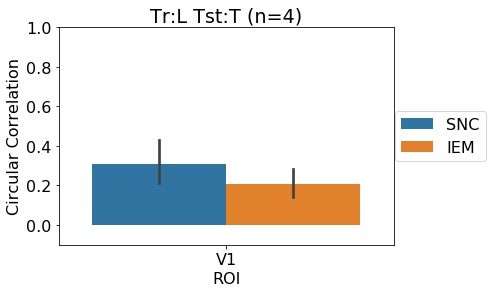

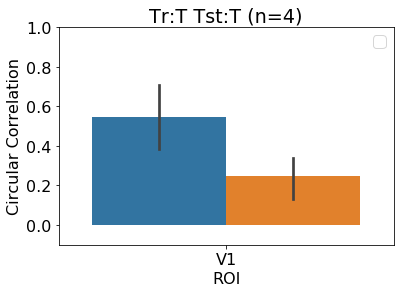

In [147]:
sns.barplot(x='ROI',y='corr',hue='Model',data=corr_coefs_B[corr_coefs_B.type=='LocTask'])
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.ylabel('Circular Correlation')
plt.title('Tr:L Tst:T (n=%d)' %(len(subjs)))
plt.ylim(-.1,1.0)
plt.show()

sns.barplot(x='ROI',y='corr',hue='Model',data=corr_coefs_B[corr_coefs_B.type=='TaskTask'])
# plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.legend('')
plt.ylabel('Circular Correlation')
plt.title('Tr:T Tst:T (n=%d)' %(len(subjs)))
plt.ylim(-.1,1.0)
plt.show()

# Visualize Serial Bias

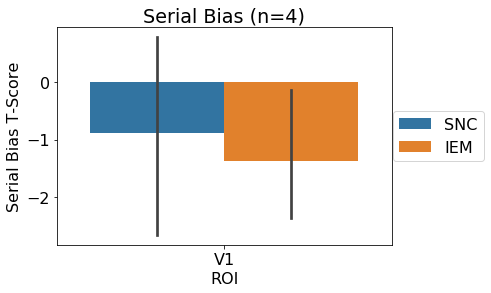

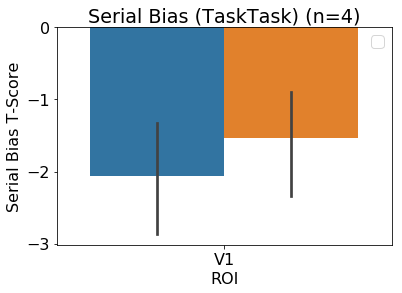

Text(0.5,1,'Serial Bias (TaskTask) (n=7)')

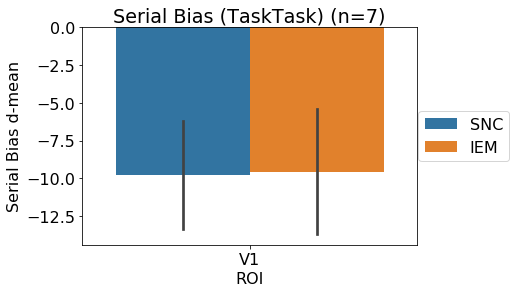

In [148]:
sns.barplot(x='ROI',y='SB_T',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Loc')])
plt.ylabel('Serial Bias T-Score')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title('Serial Bias (n=%d)' %len(subjs))
plt.show()

sns.barplot(x='ROI',y='SB_T',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Task')])
plt.ylabel('Serial Bias T-Score')
plt.legend('')
plt.title('Serial Bias (TaskTask) (n=%d)' %len(subjs))
plt.show()

sns.barplot(x='ROI',y='SB_d',hue='Model',data=BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Train=='Task')])
plt.ylabel('Serial Bias d-mean')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
plt.title('Serial Bias (TaskTask) (n=%d)' %len(subj))
plt.show()

/home/AD/tsheehan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


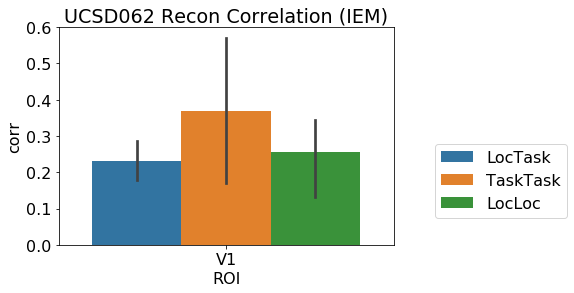

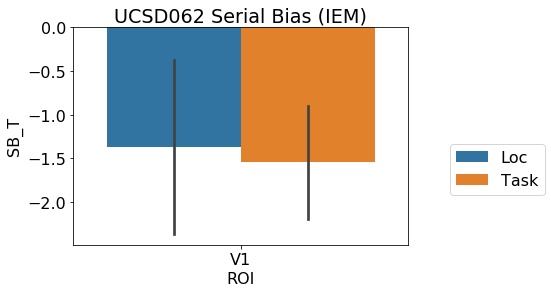

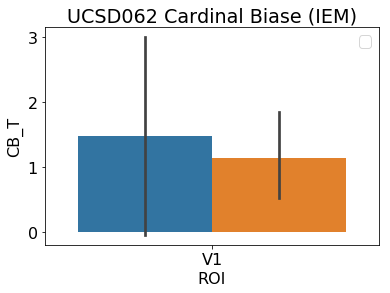

In [146]:
# summary visualize IEM
mod = 'IEM'
corr_coefs = corr_coefs_B[(BIAS_B.Model=='SNC')]
BIAS_USE = BIAS_B[(BIAS_B.Uncert=='all')&(BIAS_B.Model=='IEM')]
sns.barplot(x='ROI',hue='type',y='corr',data=corr_coefs)
plt.legend( bbox_to_anchor=(1.1, 0.5))
plt.title('%s Recon Correlation (%s)' %(subj,mod))
plt.show()

sns.barplot(x='ROI',hue='Train',y='SB_T',data=BIAS_USE)
plt.title('%s Serial Bias (%s)' %(subj,mod))
plt.legend( bbox_to_anchor=(1.1, 0.5))
plt.show()

sns.barplot(x='ROI',hue='Train',y='CB_T',data=BIAS_USE)
plt.title('%s Cardinal Biase (%s)' %(subj,mod))
plt.legend('')